In [85]:
%pylab inline
# Load islpy and islplot
from islpy import *
from islplot.plotter import *
from islplot.plotter3d import *
from IPython.display import HTML

#### Some helper methods ####
# set structural parameters (for graphical representation)
def ppSet(set) :
    pars = set.params()
    for i in range(0, pars.dim(dim_type.param)) :
        if not pars.plain_get_val_if_fixed(dim_type.param, i).is_rat() :
            pars = pars.fix_val(dim_type.param, i, i+5)
    return set.intersect_params(pars)
def ppMap(map,domain) :
    return ppSet(map.intersect_domain(domain).intersect_range(domain))

# add method apply_both to all Maps, which takes a map (function)
#   and applies it to both the domain and range
def apply_both(self, map) : return self.apply_domain(map).apply_range(map)
Map.apply_both = apply_both

# generates a loop nest for the given domain and schedule
def codegen(domain, schedule=None) :
    if schedule is None :
        scattering = domain.identity()
    else :
        scattering = schedule.intersect_domain(domain)
    astBuild = AstBuild.from_context(scattering.params())
    ast = astBuild.ast_from_schedule(scattering)
    p = Printer.to_str(scattering.get_ctx())
    p = p.set_output_format(format.C)
    p.flush()
    p = p.print_ast_node(ast)
    print(p.get_str())

# plot a domain, along with the given dependences
#  trafo specifies a transformation, that should be applied before plotting the model
def plot_model(domain, flow=None, anti=None, out=None, inp=None, trafo=None) :
    if trafo is None : trafo = domain.identity()
    domain_ = ppSet(domain.apply(trafo))
    plot_domain(domain_, vertex_color='brown')
    if flow is not None :
        flow_ = ppMap(flow.apply_both(trafo), domain_)
        plot_map(flow_, color='green')
    if anti is not None :
        anti_ = ppMap(anti.apply_both(trafo), domain_)
        plot_map(anti_, color='red')
    if out is not None :
        out_ = ppMap(out.apply_both(trafo), domain_)
        plot_map(out_, color='blue')
    if inp is not None :
        inp_ = ppMap(inp.apply_both(trafo), domain_)
        plot_map(inp_, color='gray')

Populating the interactive namespace from numpy and matplotlib


In [86]:
domain = Set("[n] -> { S[i,j,s] : 1 <= s <= 2 and 1 <= i <= n and 1 <= j <= n }")
trafo = Map("{ S[i,j,s] -> S[2*i+s-1, 2*j+s-1] }")
writes = {
	"A" : Map("{ S[i,j,2] -> A[i,j] }"),
	"B" : Map("{ : }"),
	"C" : Map("{ S[i,j,1] -> C[i,j] }")
}
reads = {
	"A" : Map("{ S[i,j,1] -> A[i+1,j] }"),
	"B" : Map("{ S[i,j,1] -> B[i,j,i+2] ; S[i,j,2] -> B[i+3, j, i+5] }"),
	"C" : Map("{ S[i,j,1] -> C[i,j-1] ; S[i,j,2] -> C[i,j] }")
}

A
{ S[i, j, 2] -> S[i' = -1 + i, j' = j, 1] }
{ S[i, j, 1] -> S[i' = 1 + i, j' = j, 2] }
{ S[i, j, 2] -> S[i' = i, j' = j, 2] }
{ S[i, j, 1] -> S[i' = i, j' = j, 1] }

C
{ S[i, j, 1] -> S[i' = i, j' = j, 2]; S[i, j, 1] -> S[i' = i, j' = 1 + j, 1] }
{ S[i, j, 2] -> S[i' = i, j' = j, 1]; S[i, j, 1] -> S[i' = i, j' = -1 + j, 1] }
{ S[i, j, 1] -> S[i' = i, j' = j, 1] }
{ S[i, j, 2] -> S[i' = i, j' = j, 2]; S[i, j, 1] -> S[i' = i, j' = -1 + j, 2]; S[i, j, 2] -> S[i' = i, j' = 1 + j, 1]; S[i, j, 1] -> S[i' = i, j' = j, 1] }

B


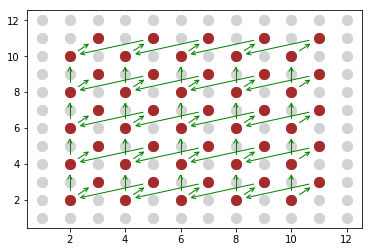

In [90]:
# compute dependences
o_sched = domain.identity()
for k in writes:
    print(k)
    if k =="B": continue # FIXME doesn't work with empty set
    
    #FIXME intersect doesn't work
    flow = writes[k].apply_range(reads[k].reverse())#.intersect(o_sched.lex_lt_map(o_sched))
    anti = reads[k].apply_range(writes[k].reverse())#.intersect(o_sched.lex_lt_map(o_sched))
    out = writes[k].apply_range(writes[k].reverse())#.intersect(o_sched.lex_lt_map(o_sched))
    inp = reads[k].apply_range(reads[k].reverse())#.intersect(o_sched.lex_lt_map(o_sched))
    
    print(flow)
    print(anti)
    print(out)
    print(inp)
    print()
    
    plot_model(domain, flow, None, None, None, trafo)